# STYLE-ALIGNED WITH REFERENCE IMAGE \& CONTENT (IMG+MUSIC)

In [1]:
# Clone the repository
!git clone https://github.com/alessioborgi/StyleAlignedDiffModels.git

# Change directory to the cloned repository
%cd StyleAlignedDiffModels
%ls

# Set up Git configuration
# !git config --global user.name "Alessio Borgi"
# !git config --global user.email "alessioborgi3@gmail.com"

!git config --global user.name "Name Surname"
!git config --global user.email "email@gmail.com"

# Stage the changes
#!git add .

# Commit the changes
#!git commit -m "Added some content to your-file.txt"

# Push the changes (replace 'your-token' with your actual personal access token)
#!git push origin main

Cloning into 'StyleAlignedDiffModels'...
remote: Enumerating objects: 1184, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 1184 (delta 45), reused 53 (delta 32), pack-reused 1113 (from 1)
Receiving objects: 100% (1184/1184), 616.94 MiB | 17.20 MiB/s, done.
Resolving deltas: 100% (605/605), done.
Updating files: 100% (172/172), done.
/content/StyleAlignedDiffModels
 audio/                           StyleAligned_Metrics.ipynb
 imgs/                            StyleAligned_Prompts.ipynb
 LICENSE                         'StyleAligned_Ref&Content(Audio).ipynb'
 music/                          'StyleAligned_Ref&Content(Audio+Music).ipynb'
 README.md                       'StyleAligned_Ref&Content(Img+Audio).ipynb'
 requirements.txt                'StyleAligned_Ref&Content(Img+Audio+Music).ipynb'
 src/                            'StyleAligned_Ref&Content(Img).ipynb'
 StyleAligned_ControlNet.ipynb   'StyleAligned_Ref&Content(I

In [2]:
# Install the required packages
!pip install -r requirements.txt > /dev/null

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albucore 0.0.13 requires numpy<2,>=1.24.4, but you have numpy 1.23.5 which is incompatible.
albumentations 1.4.13 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
chex 0.1.86 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
pandas-stubs 2.1.4.231227 requires numpy>=1.26.0; python_version < "3.13", but you have numpy 1.23.5 which is incompatible.
torchtext 0.18.0 requires torch>=2.3.0, but you have torch 2.2.2 which is incompatible.


In [3]:
from __future__ import annotations
import cv2
import copy
import torch
import einops
import mediapy
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
from typing import Any
from typing import Callable
from dataclasses import dataclass
from diffusers.utils import load_image
from torch.nn import functional as nnf
from diffusers.models import attention_processor
from diffusers.image_processor import PipelineImageInput
from transformers import DPTImageProcessor, DPTForDepthEstimation
from diffusers.utils.torch_utils import is_compiled_module, is_torch_version
from diffusers import StableDiffusionXLPipeline, DDIMScheduler, ControlNetModel, StableDiffusionXLControlNetPipeline, AutoencoderKL

from src.Handler import Handler
from src.StyleAlignedArgs import StyleAlignedArgs
from src.Tokenization_and_Embedding import prompt_tokenizazion_and_embedding, embeddings_ensemble, embeddings_ensemble_with_neg_conditioning
from src.Encode_Image import image_encoding
from src.Diffusion import Generate_Noise_Prediction, Denoising_next_step, DDIM_Process, extract_latent_and_inversion, DDIM_Inversion_Process

# For the Blip model (Content Image).
import os
from transformers import BlipProcessor, BlipForConditionalGeneration

# For the Whisper model (Content Audio).
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import librosa

# For the Music Model (Content AudioMusic).
import hashlib
import torchaudio
from laion_clap import CLAP_Module

# Create Alias for torch.tensor to increase readability.
T = torch.tensor
TN = T

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

#### Model Load

In [4]:
# Create a DDIMScheduler object with specific parameters
scheduler = DDIMScheduler(
    beta_start=0.00085,            # Starting value of beta for the noise schedule
    beta_end=0.012,                # Ending value of beta for the noise schedule
    beta_schedule="scaled_linear", # Type of beta schedule to use, here it is scaled linear
    clip_sample=False,             # Whether to clip the samples to a certain range
    set_alpha_to_one=False         # Whether to set alpha to one
)

# Load the Stable Diffusion XL Reference_Pipeline with a pretrained model
Reference_Pipeline = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",  # Model name or path
    torch_dtype=torch.float16,                   # Data type for PyTorch tensors
    variant="fp16",                              # Variant of the model, here it is fp16 (16-bit floating point)
    use_safetensors=True,                        # Whether to use safe tensors
    scheduler=scheduler                          # Use the scheduler defined above
).to("cuda")                                     # Move the pipeline to the CUDA device (GPU)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
# 1) VanGogh Painting
# Set the source style, prompt and path.
#src_style = "Van Gogh round painting"
#src_prompt = f'The starry night, {src_style}.'
#reference_image_path = './imgs/original.jpg'

# 2) Cubism Painting
# src_style = "cubism painting"
# src_prompt = f'Two men smoking water pipe, {src_style}.'
# reference_image_path = './imgs/Picasso_Smoking_Water_Pipe.jpeg'


# 3) Kid Drawing
# src_style = "Kid Drawing"
# src_prompt = f'A city with two houses and a church, {src_style}.'
# reference_image_path = './imgs/kid_drawing.jpeg'

# 4) Medieval Painting
# src_style = "Medieval Painting"
# src_prompt = f'Man laying in a bed, {src_style}.'
# reference_image_path = './imgs/medieval-bed.jpeg'

src_style = "Macro"
src_prompt = f'SuperMario Bros standing, {src_style}.'
reference_image_path = './imgs/supermario.jpg'

# Setting the number of inference steps in the Diffusion Inversion Process.
num_inference_steps = 50

# Setting the Guidance Scale for the Diffusion Inversion Process.
guidance_scale = 10.0

# 1) Normal Painting
# These are some parameters you can Adjust to Control StyleAlignment to Reference Image.
#style_alignment_score_shift = np.log(2)  # higher value induces higher fidelity, set 0 for no shift
#style_alignment_score_scale = 1.0  # higher value induces higher, set 1 for no rescale

# 2) Very Famous Paintings
style_alignment_score_shift = np.log(1)
style_alignment_score_scale = 0.5


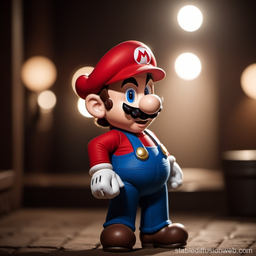

In [6]:
# Load the reference image and resize it to 1024x1024 pixels.
ref_image = np.array(load_image(reference_image_path).resize((1024, 1024)))

# Display the output image.
mediapy.show_image(ref_image, title="Reference Image for Style Alignment", height=256)

In [7]:
# Defining a type alias for the Diffusion Inversion Process type of callable.
Diff_Inversion_Process_Callback = Callable[[StableDiffusionXLPipeline, int, T, dict[str, T]], dict[str, T]]

### CONTENT IMAGE USING BLIP-1

In [8]:
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base")

preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [9]:
def generate_description(image):
    inputs = processor(image, return_tensors="pt")
    out = model.generate(**inputs)
    description = processor.decode(out[0], skip_special_tokens=True)
    return description

In [10]:
def load_content_images(image_paths):
    """
    Load images from a list of file paths.

    Parameters:
    image_paths (List[str]): A list of file paths to the images.

    Returns:
    List[Image.Image]: A list of PIL Image objects.
    """
    content_images = []
    for img_path in image_paths:
        try:
            image = Image.open(img_path)
            content_images.append(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    return content_images

In [11]:
directory_path = "/content/StyleAlignedDiffModels/imgs/content_imgs/"
set_of_images = ["ladybug.jpeg", "PolarBear.jpeg", "olive_tree.jpg"]
set_of_images_path = [directory_path + img for img in set_of_images]
print(set_of_images_path)
content_images = load_content_images(set_of_images_path)  # Implement this as needed

['/content/StyleAlignedDiffModels/imgs/content_imgs/ladybug.jpeg', '/content/StyleAlignedDiffModels/imgs/content_imgs/PolarBear.jpeg', '/content/StyleAlignedDiffModels/imgs/content_imgs/olive_tree.jpg']


In [12]:
extracted_prompts_img = [generate_description(image).strip() + "." for image in content_images]
print(extracted_prompts_img)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1249: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


['ladybird ladybird ladybird ladybird ladybird ladybird ladybird ladybird ladybird lady.', 'a polar bear on an iceberg.', 'olive tree in the field.']


### MUSIC CONTENT

In [13]:

# Function to generate a unique seed from the audio file
def generate_seed_from_audio(audio_path):
    with open(audio_path, 'rb') as f:
        audio_data = f.read()
    return int(hashlib.md5(audio_data).hexdigest(), 16) % (2**32)

# Function to generate music description based on genre and general characteristics
def generate_music_description(audio_path):
    # Generate a unique seed based on the audio file
    seed = generate_seed_from_audio(audio_path)

    # Set the seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

    # Instantiate the CLAP model
    model = CLAP_Module()

    # Load your audio file
    waveform, sample_rate = torchaudio.load(audio_path)

    # Resample if necessary (CLAP expects 48kHz)
    if sample_rate != 48000:
        resampler = torchaudio.transforms.Resample(sample_rate, 48000)
        waveform = resampler(waveform)

    # Make sure it's mono
    if waveform.shape[0] > 1:
        waveform = torch.mean(waveform, dim=0, keepdim=True)

    # Ensure the tensor is on the CPU
    audio_tensor = waveform.clone().detach().cpu()

    # Genre-specific queries with different music genres
    genre_queries = [
        "Rock music", "Pop music", "Classical music",
        "Jazz music", "Electronic music", "Hip hop music",
        "Country music", "Blues music", "Reggae music",
        "Folk music", "Metal music", "Funk music",
        "Soul music", "R&B music", "Disco music",
        "Punk rock music", "Indie rock music", "Alternative rock music",
        "EDM music", "Techno music", "House music",
        "Ambient music", "Trap music", "Gospel music",
        "Orchestral music", "World music", "Latin music",
        "Lofi music", "Instrumental music", "Acoustic music"
    ]

    # General characteristic queries starting with "The music sounds"
    general_queries = [
        # Moods and Emotions
        "The music sounds happy", "The music sounds sad", "The music sounds angry",
        "The music sounds peaceful", "The music sounds energetic", "The music sounds melancholic",
        "The music sounds romantic", "The music sounds mysterious", "The music sounds anxious",
        "The music sounds triumphant", "The music sounds nostalgic", "The music sounds dreamy",

        # Tempo and Rhythm
        "The music sounds fast", "The music sounds slow", "The music sounds moderate",
        "The music has a strong beat", "The music has a complex rhythm", "The music has a steady rhythm",
        "The music is danceable", "The music has a syncopated rhythm",

        # Instruments
        "The music features a piano", "The music features a guitar", "The music features drums",
        "The music features a violin", "The music features a saxophone", "The music features a trumpet",
        "The music features synthesizers", "The music features an orchestra", "The music features a bass guitar",
        "The music features vocals", "The music is purely instrumental",

        # Characteristics
        "The music is melodic", "The music is harmonic", "The music is dissonant",
        "The music has a catchy chorus", "The music has complex chord progressions",
        "The music has a strong bassline", "The music has layered textures",
        "The music has a minimalist style", "The music has a rich orchestration",
        "The music has repetitive patterns", "The music has dynamic contrasts",

        # Time periods
        "The music sounds like it's from the 1950s", "The music sounds like it's from the 1960s",
        "The music sounds like it's from the 1970s", "The music sounds like it's from the 1980s",
        "The music sounds like it's from the 1990s", "The music sounds contemporary",

        # Production qualities
        "The music has high production value", "The music sounds lo-fi",
        "The music has a lot of reverb", "The music uses heavy distortion",
        "The music has a clean sound", "The music has a raw, unpolished sound",

        # Use cases
        "The music is suitable for studying", "The music is good for workouts",
        "The music is perfect for relaxation", "The music is great for parties",
        "The music would work well in a film soundtrack"
    ]

    # Function to get similarities
    def get_similarities(audio_tensor, queries):
        # Ensure audio tensor is on the CPU
        audio_embeddings = model.get_audio_embedding_from_data(x=audio_tensor, use_tensor=True)

        # Get text embeddings (which are already on the CPU as a NumPy array)
        text_embeddings = model.get_text_embedding(queries)

        # Convert audio embeddings to CPU if they are on GPU
        audio_embeddings = audio_embeddings.cpu()

        # Calculate similarities
        similarities = (audio_embeddings @ torch.tensor(text_embeddings).T).squeeze()
        return sorted(zip(queries, similarities), key=lambda x: x[1], reverse=True)

    # Get genre similarities
    genre_results = get_similarities(audio_tensor, genre_queries)

    # Get general similarities
    general_results = get_similarities(audio_tensor, general_queries)

    # Select the top general characteristic description
    top_general_descriptions = [query for query, _ in general_results[:1]]

    # Select the top genre description
    top_genre_description = genre_results[0][0]

    # Combine the top general description with the genre description
    combined_description = f"{top_general_descriptions[0]} Genre: {top_genre_description}."

    print("Generated Music Description:")
    print(combined_description)

    return combined_description


In [14]:
# Generate music style prompts from the music files
music_file = "/content/StyleAlignedDiffModels/music/futuristic.wav"
music_style_prompt = generate_music_description(music_file)
print("Music Style Caption:", music_style_prompt)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Generated Music Description:
The music has high production value Genre: Trap music.
Music Style Caption: The music has high production value Genre: Trap music.


### IMG + MUSIC CONTENT

In [15]:
print(music_style_prompt)

The music has high production value Genre: Trap music.


In [16]:
# Step 3: Combine each image description with its corresponding audio description
combined_descriptions = [
    img_desc + music_style_prompt
    for img_desc in extracted_prompts_img
]

In [17]:
# Set of prompts to generate images for. The first refers to the Reference Image. The other to generate images.
prompts = [
    src_prompt,  # Reference Image Prompt
    *combined_descriptions  # Prompts extracted from content + audio images
]
print(prompts)

# Append the reference style to each of subsequent prompts for generating images with the same Style.
for i in range(1, len(prompts)):
    prompts[i] = f'{prompts[i]}, {src_style}.'

# Configure the StyleAligned Handler using the StyleAlignedArgs.
handler = Handler(Reference_Pipeline)
sa_args = StyleAlignedArgs(
    share_group_norm=True,
    share_layer_norm=True,
    share_attention=True,
    adain_queries=True,
    adain_keys=True,
    adain_values=False,
    style_alignment_score_shift=style_alignment_score_shift,
    style_alignment_score_scale=style_alignment_score_scale)
handler.register(sa_args)

['SuperMario Bros standing, Macro.', 'ladybird ladybird ladybird ladybird ladybird ladybird ladybird ladybird ladybird lady.The music has high production value Genre: Trap music.', 'a polar bear on an iceberg.The music has high production value Genre: Trap music.', 'olive tree in the field.The music has high production value Genre: Trap music.']


100%|██████████| 50/50 [00:23<00:00,  2.10it/s]


  0%|          | 0/50 [00:00<?, ?it/s]


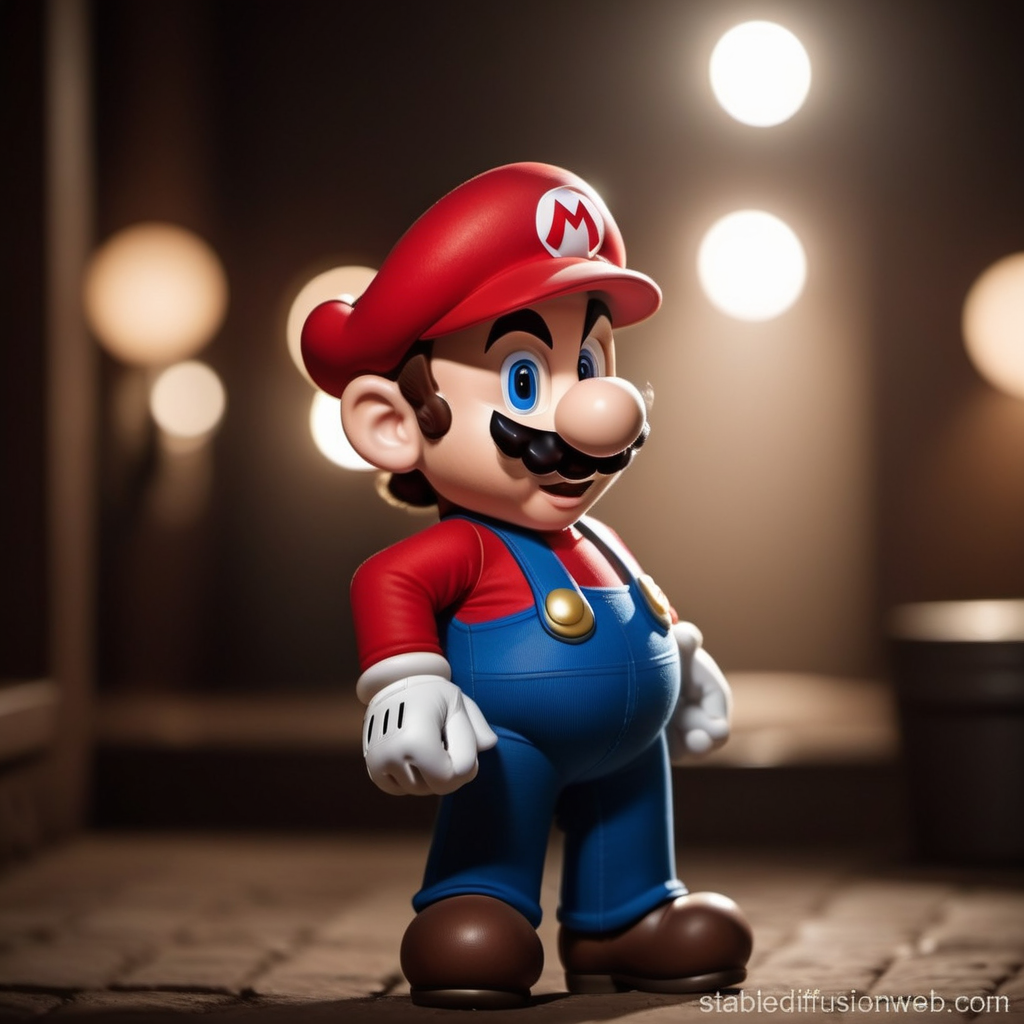
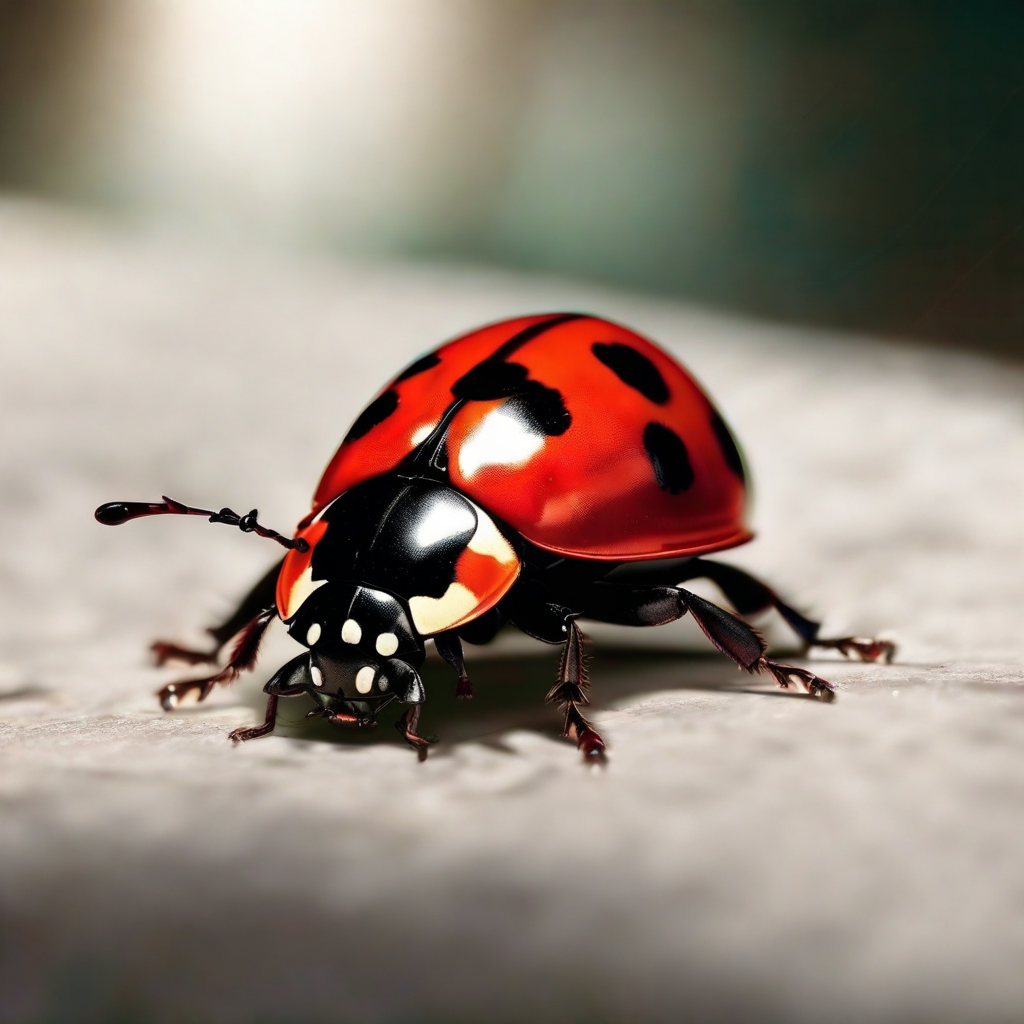
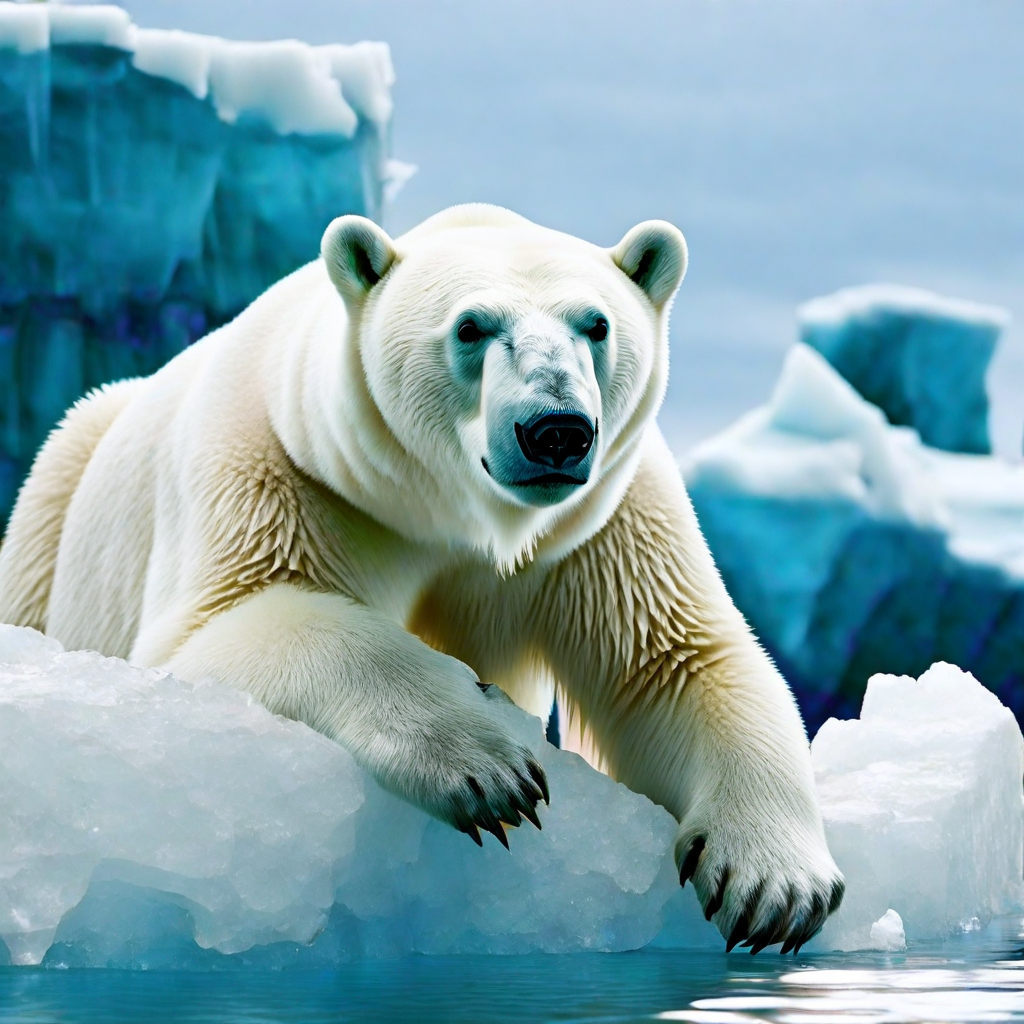
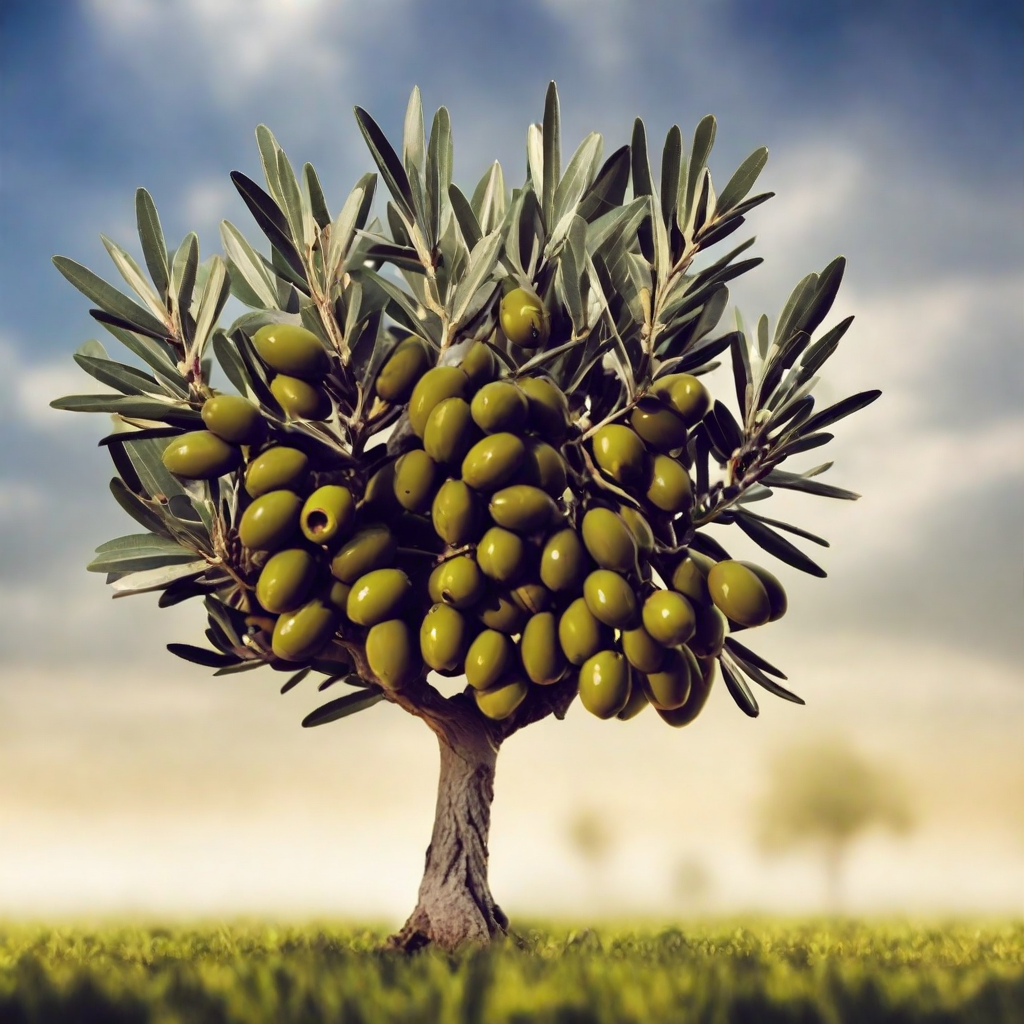

In [18]:
# Execute the Diffusion Inversion Process to map the reference image to its latent representation.
DDIM_inv_result = DDIM_Inversion_Process(Reference_Pipeline, ref_image, src_prompt, num_inference_steps, 2)

# Extract the latent representation from the Diffusion Inversion Result that can be used to guide the generation of new images in the desired style.
latent_vector_ref_img, inversion_callback = extract_latent_and_inversion(DDIM_inv_result, offset=5)

# Create a Random Number Generator on the CPU.
rand_gen = torch.Generator(device='cpu').manual_seed(10)

# Generate the images using the latent representation of the reference image as guidance.
latents = torch.randn(len(prompts), 4, 128, 128,                            # Random Latent Vectors shape
                      device='cpu',                                         # Latent Vectors on CPU.
                      generator=rand_gen,                                   # Random Number Generator.
                      dtype=Reference_Pipeline.unet.dtype,).to('cuda:0')    # Data Type of the Latent Vectors (same as required by the model's UNet).

# Set the first latent vector to the latent representation of the reference image extracted before.
latents[0] = latent_vector_ref_img

# Generate the images using the provided prompts and the latent vectors.
images_a = Reference_Pipeline(prompts,                                      # Prompts to generate images for.
                              latents=latents,                              # Latent Vectors to guide the generation of images.
                              callback_on_step_end=inversion_callback,      # Callback to update the latent vectors during the generation process.
                              num_inference_steps=num_inference_steps,      # Number of Inference Steps to generate the images.
                              guidance_scale=guidance_scale).images         # Guidance Scale to control the influence of the latent vectors on the generated images.

# Display the generated images.
handler.remove()
mediapy.show_images(images_a, titles=[p[:-(len(src_style) + 3)] for p in prompts])

In [19]:
import tensorflow as tf
import torch

def clear_gpu_memory():
    # Clear TensorFlow GPU memory
    tf.keras.backend.clear_session()
    tf.compat.v1.reset_default_graph()

    # Clear PyTorch GPU memory
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()

    print("GPU memory cleared.")

# Execute the function to clear GPU memory
clear_gpu_memory()


GPU memory cleared.
